In [1]:
import numpy as np 
import pandas as pd
from helpers import * 
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
ufc = pd.read_csv('ufc-master.csv')

# Objective and Forecast 

## Objective and Context

## Sources 

## Forecast 

# The Data 

In [2]:
ufc.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,1:20,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,165.0,200.0,400.0,1200.0,900.0,600.0


Let's start with what we're trying to predict - the target. In this data set, it's the 'Winner' column, which denotes the winner of each bout (the 'Red' corner or the 'Blue' corner). 

In [3]:
print(f"There are {ufc['Winner'].value_counts()[0]} winners in the Red corner and {ufc['Winner'].value_counts()[1]} in the Blue.")

There are 2859 winners in the Red corner and 2037 in the Blue.


These are imbalanced. Before we do any EDA or model building we will have to resample. 

In [4]:
num, cat = num_and_cat(ufc)

print(f"There are {len(num)-1} continuous features and {len(cat)} categorical features.")

There are 103 continuous features and 15 categorical features.


(Describe column breakdown here)

In [5]:
ufc.isna().sum()

R_fighter        0
B_fighter        0
R_odds           1
B_odds           0
R_ev             1
              ... 
b_dec_odds     819
r_sub_odds    1049
b_sub_odds    1061
r_ko_odds     1049
b_ko_odds     1062
Length: 119, dtype: int64

Healthy smattering of nulls across the data set. Let's do some basic inspection and see which columns are mostly nulls. These will be largely useless. 

In [6]:
mostly_nulls = []

for col in ufc.columns:
    if ufc[col].isna().sum() > (0.5 * ufc.shape[0]):
        mostly_nulls.append(col)

print(f"There are {len(mostly_nulls)} columns that are more than half null.")
mostly_nulls

There are 29 columns that are more than half null.


['B_match_weightclass_rank',
 'R_match_weightclass_rank',
 "R_Women's Flyweight_rank",
 "R_Women's Featherweight_rank",
 "R_Women's Strawweight_rank",
 "R_Women's Bantamweight_rank",
 'R_Heavyweight_rank',
 'R_Light Heavyweight_rank',
 'R_Middleweight_rank',
 'R_Welterweight_rank',
 'R_Lightweight_rank',
 'R_Featherweight_rank',
 'R_Bantamweight_rank',
 'R_Flyweight_rank',
 'R_Pound-for-Pound_rank',
 "B_Women's Flyweight_rank",
 "B_Women's Featherweight_rank",
 "B_Women's Strawweight_rank",
 "B_Women's Bantamweight_rank",
 'B_Heavyweight_rank',
 'B_Light Heavyweight_rank',
 'B_Middleweight_rank',
 'B_Welterweight_rank',
 'B_Lightweight_rank',
 'B_Featherweight_rank',
 'B_Bantamweight_rank',
 'B_Flyweight_rank',
 'B_Pound-for-Pound_rank',
 'finish_details']

They're all the rank variables. We could do with getting rid of them. 

In [7]:
ufc = ufc.drop(mostly_nulls, axis=1)

Let's resample and encode.

In [8]:
ufc_feats = ufc.drop(['Winner'], axis=1)
ufc_targ = [0 if victor == 'Red' else 1 for victor in ufc['Winner']]

In [9]:
ufc_feats_rs, ufc_targ_rs = resample_dataframe(ufc_feats, ufc_targ)

In [10]:
ufc_feats_rs.shape

(5718, 89)

In [11]:
sum(ufc_targ_rs) / len(ufc_targ_rs)

0.5

# EDA 

## Odds and EV 

In [12]:
ufc_comb_rs = ufc_feats_rs.copy()
ufc_comb_rs['Winner'] = ufc_targ_rs

In [13]:
red_wins = ufc_comb_rs[ufc_comb_rs['Winner'] == 0]
blue_wins = ufc_comb_rs[ufc_comb_rs['Winner'] == 1]

In [14]:
red_vs_blue(red_wins, blue_wins, 'B_ev')

When Red is the underdog, it's more likely to win. 

Let's take a quick look at what the categorical columns entail. 

In [15]:
cat

['R_fighter',
 'B_fighter',
 'date',
 'location',
 'country',
 'Winner',
 'title_bout',
 'weight_class',
 'gender',
 'B_Stance',
 'R_Stance',
 'better_rank',
 'finish',
 'finish_details',
 'finish_round_time']

Fighters' names, the date, location, country, and gender are identification variables. Since most UFC fights happen in Las Vegas, there's a disproportionately large amount of events happening there. The date is most likely a non-factor, and gender is consistent for either fighter (no inter-gender fights). Weight class, title bout, and better rank are probably our best bets for a reasonable correlation since logically they could be condusive to better winning situations

	- If a fighter has a better rank, we generally assume that fighter is more skilled and likely to win
	- Different weight classes may have different trends. For example, heavyweight has much more variability than the lighter weight classes, since raw power of heavyweight fighters is more due to their stature, regardless of skill (so 'a puncher's chance' is much higher)
	- If a fight is a title bout, it has different implications than a normal fight for a fighter. This influences their preparation, mentality, and tenacity in the fight. In addition, title fights are 5 rounds, whereas non-title bouts are 3. This marks a significant step up in stamina concerns. 

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat:
    if col in ufc_comb_rs.columns:
        ufc_comb_rs[col] = le.fit_transform(ufc_comb_rs[col])

(Do the graphs - there isn't much difference on either end lol)

Let's pull some of the best correlations - maybe the top 15 - and see if they're any collinearity between. 

In [17]:
corr_dict = {}

for col in ufc_comb_rs.columns:
    corr_dict[col] = ufc_comb_rs[col].corr(ufc_comb_rs['Winner'])

In [18]:
sorted_correlation = sorted(corr_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 15 column names
top_15_columns = [column for column, correlation in sorted_correlation[:15]]

# Print the result
print("Top 15 columns based on correlation values:")
print(top_15_columns)

top_15_columns.append('Winner')

Top 15 columns based on correlation values:
['R_odds', 'R_ev', 'R_current_lose_streak', 'B_current_win_streak', 'B_avg_TD_landed', 'B_Reach_cms', 'weight_class', 'B_Height_cms', 'B_avg_SIG_STR_landed', 'B_Weight_lbs', 'B_avg_SUB_ATT', 'B_avg_SIG_STR_pct', 'B_draw', 'B_avg_TD_pct', 'B_win_by_Decision_Unanimous']


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
def corr_heatmap(df, cols):
    
    heatmap_data = df[cols]
    correlation_matrix = heatmap_data.corr()
    
    plt.figure(figsize=(10,8))
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Numerical Columns')
    plt.show()

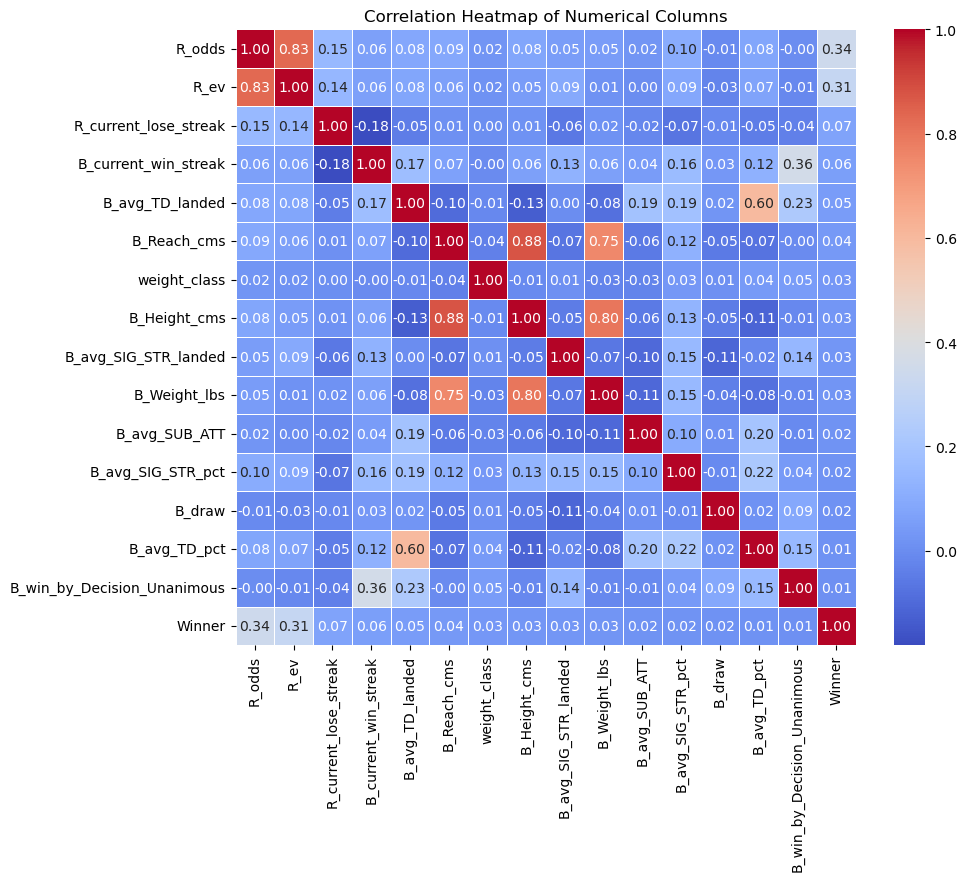

In [21]:
corr_heatmap(ufc_comb_rs, top_15_columns)

Odds and EV for the red corner are expectedly the most correlated with the winner value. We also have some expected collinearity with the weight variables (fighters must weigh in at roughly the same weight for fights), weight, reach, and height (the bigger you are, the heavier you are), and so on. Another thing to notice is that the performance details (significant strikes, takedown percentage, etc.) are all negatively correlated with the target, with a similar degree of significance. It may be useful to reduce dimensionality by combining these. 

Finally, a lot of features are mirrors of each other (red side vs blue side). We may benefit from combining them into one variable using a difference. 

## Insights 

It can be seen that - at least as far as this data set goes - the features are anchored against a Blue win (remember - a Red win is encoded as 0 and a Blue win is encoded as 1, so the lower the correlation, the more it tends to a red win). Since we're predicting betting odds, we want to maximize the proportion of predicted favorable bets that are actually favorable. This can be measured with the precision metric. However, we have to consider managing the variabiltiy of the dataset since it's so dimensionally complex. We can do this by leveraging both the precision metric and the F1-score (which is a harmonic mean of the precision and recall values). This will ensure attempting to find a balnce between making accurate positive predictions and capturing as many favorable bets as possible. 

# Feature Engineering Approaches and Model Considerations

## What model to use?

I chose to focus on ensemble learning algorithms - particularly Random Forest Classifier, Gradient Boosting Classifier, and Adaboost Classifier. 

My logic is as follows:

	- Ensemble learning methods do well with dimensionally complex data, are robust to outliers, and can handle non-linearity really well
	- The probabilistic logic behind ensemble learning algorithms lends itself very well to our final goal - determining the most favorable bet 
	- Ensemble algorithms do very well with high variability and inherently reduce overfitting with regularization 
	- Ensemble algorithms are also very adept at discerning feature importance, which is paramount given the complexity of our dataset

## In short:

I tried 7 feature engineering approaches

	- Approach 1: The baseline, with nothing besides basic nulls replaced with the mean (if continuous) or mode (if categorical). Purely to assess baseline score.
	- Approach 2: Grab all the continous columns whose correlation with the target exceed a certain threshold value (I chose 0.25, negative or positive)
	- Approach 3: Do the same as approach 2, but with encoded categorical features as well
	- Approach 4: Combine all the individual feature columns that have counterparts for each color (for example, 'R_Weight_lbs' and 'B_Weight_lbs'), and combine them by taking their difference
	- Approach 5: Do the same, but combine them with categorical variables from approach 3
	- Approach 6: Take a mix of continous features from approach 2, but seek out individual features that are right skewed 
	- Approach 7: Approach 6, but replaced with some of the engineered difference features from approach 4

For the sake of clarity, I've chosen to focus on my results, and created custom functions to execute and analyze these approaches. I'll be highlighting the baseline score and my best scored approach, but to look at the specific code for each approach and how it was all put together, please refer to `helpers.py` in the containing Git repository.

The approach I found worked best with ensemble methods was approach 6, but I found that replacing nulls with values was creating too much noise. I chose instead to drop the nulls of those columns entirely. In addition, I combined the performance variables ( `sig_str_pct`, `td_pct`, `subs_att` ) for each fighter into one variable called `perf_idx`. I then subtracted the red fighter's' `perf_idx` values from the blue fighter's and created the `perf_diff` difference variable to reduce dimensionality. 

Let's prepare the baseline dataset and the best approach dataset, along with the models, and see what we find. 

In [22]:
AD = data_prep_and_feat_engineering(ufc, cat_thresh=0.001, squared_thresh=0.0625)

In [23]:
baseline_feats, baseline_targ = break_down_bundle(AD['approach 1'])

In [24]:
best_approach = ufc.copy() ## creating a new copy of the data to manipulate
best_cols = AD['approach 6'][1] ## features from approach 6
best_approach, best_cols = performance_index(best_approach, best_cols, diff=True) ## creating performance index difference variable

In [25]:
best_approach.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds,R_perf_idx,B_perf_idx,perf_diff
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0,0.608276,1.355765,-0.747489
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,450.0,350.0,700.0,1100.0,550.0,120.0,0.804363,0.929946,-0.125583
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,550.0,275.0,275.0,1400.0,600.0,185.0,1.823102,0.541941,1.281161
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0,0.502096,0.340000,0.162096
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,165.0,200.0,400.0,1200.0,900.0,600.0,1.007373,0.682422,0.324951


In [26]:
### dropping nulls
best_approach = best_approach.dropna(subset=best_cols)
print(f"Information loss : {ufc.shape[0] - best_approach.shape[0]} entries")
print(f"Remaining information: {best_approach.shape[0]} entries")

Information loss : 954 entries
Remaining information: 3942 entries


Still a decent chunk of information

In [27]:
### encoding and separating target, creating features 

best_feats = best_approach[best_cols]
targ = [0 if victor == 'Red' else 1 for victor in best_approach['Winner']]

In [28]:
### resampling 

best_feats_rs, best_targ_rs = resample_dataframe(best_feats, targ)

In [29]:
baseline_feats_rs, baseline_targ_rs = resample_dataframe(baseline_feats, baseline_targ)

Let's encode the categorical variables in either, and we'll also standardize the continous features in our best approach. 

In [30]:
le = LabelEncoder()

for col in baseline_feats_rs:
    if col in cat:
        baseline_feats_rs[col] = le.fit_transform(baseline_feats_rs[col])

for col in best_feats_rs:
    if col in cat:
        best_feats_rs[col] = le.fit_transform(best_feats_rs[col])

In [31]:
from sklearn.preprocessing import StandardScaler

to_standardize = ['B_age', 'R_ev', 'R_odds', 'R_Reach_cms', 'R_Weight_lbs', 'R_age', 'perf_diff']


In [32]:
scale = StandardScaler()

scale.fit(best_feats_rs[to_standardize])

best_feats_rs[to_standardize] = scale.transform(best_feats_rs[to_standardize])

Finally, we'll initialize our model instances and see how it does. 

# Model Selection

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

In [34]:
dummy = DummyClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
bag = BaggingClassifier()
xgb = XGBClassifier()
extra = ExtraTreesClassifier()

dummy = {'dummy' : dummy}
ml = {'rf' : rf,
      'gb' : gb,
      'bag' : bag,
      'xgb' : xgb,
      'extra' : extra}

Baseline Score - 

In [35]:
simulate(baseline_feats_rs, baseline_targ_rs, dummy)

dummy
0.49570552147239266


In [36]:
simulate(best_feats_rs, best_targ_rs, ml)

rf
0.7934426229508197
gb
0.6830601092896175
bag
0.7628415300546448
xgb
0.7683060109289618
extra
0.7934426229508197


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

def simulate(feats, targ, ml_dict):
    X_train, X_test, y_train, y_test = train_test_split(feats, targ, random_state=0, test_size=0.2)
    acc = {}
    pres = {}
    f1 = {}
    
    for ml in ml_dict.keys():
        model = ml_dict[ml]
        model.fit(X_train, y_train)
        model_preds = model.predict(X_test)
        acc_score = accuracy_score(model_preds, y_test)
        pre_score = precision_score(y_test, model_preds)
        f_score = f1_score(y_test, model_preds)
        
        acc[ml] = acc_score
        pres[ml] = pre_score
        f1[ml] = f_score
        
        print(ml)
        print(f"Accuracy = {acc_score:.2f} Precision - {pre_score:.2f} F1 Score - {f_score:.2f}")
        
    return acc, pres, f1

In [38]:
accuracies, precisions, f_one = simulate(best_feats_rs, best_targ_rs, ml)

rf
Accuracy = 0.79 Precision - 0.78 F1 Score - 0.79
gb
Accuracy = 0.68 Precision - 0.67 F1 Score - 0.70
bag
Accuracy = 0.78 Precision - 0.78 F1 Score - 0.78
xgb
Accuracy = 0.77 Precision - 0.75 F1 Score - 0.78
extra
Accuracy = 0.81 Precision - 0.83 F1 Score - 0.80


Extra Trees Classifier does the best in all three.

In [39]:
import plotly.graph_objects as go

In [40]:
def display_scores(data_dict, name):
    
    columns = list(data_dict.keys())
    values = list(data_dict.values())
    fig = go.Figure(go.Bar(x=columns, y=values, marker_color='skyblue'))
    fig.update_layout(
		title=f'Model {name}',
		xaxis=dict(title='Models'),
		yaxis=dict(title='Values'),
	)
    
    fig.show()

In [41]:
display_scores(accuracies, name='Accuracy')

In [42]:
display_scores(precisions, name='Precision')

In [43]:
display_scores(f_one, name='F1 Score')

## Cross Validation 

Next we pick our best two for cross validation, to ensure consistency in scores. This is more just to make sure the higher Extra Trees Classifier score wasn't a fluke. 

In [47]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

In [48]:
def cross_val_report(model, feats, targ, num_folds):
    
    kf = KFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    accuracy = make_scorer(accuracy_score)
    precision = make_scorer(precision_score)
    f1_scorer = make_scorer(f1_score)
    
    acc_cv = cross_val_score(model, feats, targ, cv=kf, scoring=accuracy)
    pre_cv = cross_val_score(model, feats, targ, cv=kf, scoring=precision)
    f1_cv = cross_val_score(model, feats, targ, cv=kf, scoring=f1_scorer)
    
    print(f'Scores for {num_folds}-fold Cross-Validation: - Extra Trees')
    print(f'Accuracy - {np.mean(acc_cv):.2f} Precision - {np.mean(pre_cv):.2f} F1-Score - {np.mean(f1_cv):.2f}')

In [49]:
cross_val_report(extra, best_feats_rs, best_targ_rs, num_folds=5)

Scores for 5-fold Cross-Validation: - Extra Trees
Accuracy - 0.81 Precision - 0.83 F1-Score - 0.81


Looks like we've got our model. Let's move onto hyperparameter tuning

# Hyperparameters

## Extra Trees Algorithm

Extra Trees works more or less the same way as any tree-based algorithm - a number of decision trees (sets of if-then logic based on the features to predict the outcome of the target) are created, each with their own method. The diversity of these methods creates extreme variance within their predictions. However, as we've learned through the course of human history, an efficient way to center the cacophony of opinion into a more rational and consist single voice is the simple majority vote. The algorithm takes the most popular guess for each prediction. 

Extra trees adds another layer of randomness - for the decision made at the split of each level of the tree (the leaves of which are predictions), a random subset of features is considered instead of the entire bunch. In addition, the algorithm chooses split thresholds randomly instead of trying to find one that reduces entropy (in a sense, the level of randomness). This creates an even more erratic model and introduces another level of diversity. 

There are two concepts to balance here - variance and bias, overfitting and underfitting. We want a model with a diverse range of methods but consistent enough to pick up on the most effective paths to prediction. 

We can increase the number of trees to draw votes from to increase variance, or we can curtail the maximum length of a tree (effectively truncating the number of decisions it's allowed) to create a more rigid model that picks up on the more common trends among trees, increasing bias. 

In [58]:
### Testing Number of Estimators 

xt_default = ExtraTreesClassifier(random_state=0) ## Default n_estimators = 100, max_depth = None
xt_moreEst = ExtraTreesClassifier(random_state=0, n_estimators=175)
xt_lessEst = ExtraTreesClassifier(random_state=0, n_estimators=50)

In [59]:
cross_val_report(xt_moreEst, best_feats_rs, best_targ_rs, num_folds=5)

Scores for 5-fold Cross-Validation: - Extra Trees
Accuracy - 0.81 Precision - 0.83 F1-Score - 0.80


In [52]:
cross_val_report(xt_lessEst, best_feats_rs, best_targ_rs, num_folds=5)

Scores for 5-fold Cross-Validation: - Extra Trees
Accuracy - 0.81 Precision - 0.83 F1-Score - 0.80


There doesn't seem to be much of a difference in any case. What about the max depth of trees

In [53]:
xt_deep = ExtraTreesClassifier(random_state=0, max_depth=10)
xt_deeper = ExtraTreesClassifier(random_state=0, max_depth=20)

In [54]:
cross_val_report(xt_deep, best_feats_rs, best_targ_rs, num_folds=5)

Scores for 5-fold Cross-Validation: - Extra Trees
Accuracy - 0.69 Precision - 0.69 F1-Score - 0.68


In [55]:
cross_val_report(xt_deeper, best_feats_rs, best_targ_rs, num_folds=5)

Scores for 5-fold Cross-Validation: - Extra Trees
Accuracy - 0.79 Precision - 0.78 F1-Score - 0.80


After trying these combinations, I tried a few more with a parameter grid using GridSearchCV. The scores seemed to all converge around 0.80, so that seems like the best performance we can accept. 

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=extra, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search.fit(best_feats_rs, best_targ_rs)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)


Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 73.02%


In [62]:
extra_final = ExtraTreesClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=0)

In [63]:
extra = {'extra' : extra_final}

In [65]:
acc, prec, f1 = simulate(best_feats_rs, best_targ_rs, extra)

extra
Accuracy = 0.81 Precision - 0.84 F1 Score - 0.80


In [66]:
b_acc, b_prec, b_f1 = simulate(baseline_feats_rs, baseline_targ_rs, dummy)

dummy
Accuracy = 0.50 Precision - 0.50 F1 Score - 0.66


In [71]:
b_acc

{'dummy': 0.49570552147239266}

In [74]:
print(f'Final Accuracy score is {acc["extra"]:.2f}, a {acc["extra"]-b_acc["dummy"]:.2f} increase from baseline')
print(f'Final Precision score is {prec["extra"]:.2f}, a {prec["extra"]-b_prec["dummy"]:.2f} increase from baseline')
print(f'Final F1 score is {f1["extra"]:.2f}, a {f1["extra"]-b_f1["dummy"]:.2f} increase from baseline')

Final Accuracy score is 0.81, a 0.31 increase from baseline
Final Precision score is 0.84, a 0.34 increase from baseline
Final F1 score is 0.80, a 0.14 increase from baseline
